## Adding new particles to a ParticleSet during runtime


There are use-cases, where it is important to be able to add particles 'on-the-fly', during the runtime of a Parcels simulation.

Unfortuantely, Parcels does not (yet) support adding new particles _within_ a `Kernel`. A workaround is to temporarily leave the `execution()` call to add particles via the `ParticleSet.add()` method, before continuing with `execution()`.

See the example below, where we add 'mass' to a particle each timestep, based on a probablistic condition, and then split the particle once its 'mass' is larger than 5


In [75]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

In [76]:
# Load the CopernicusMarine data in the Agulhas region from the example_datasets
example_dataset_folder = parcels.download_example_dataset(
    "CopernicusMarine_data_for_Argo_tutorial"
)

ds = xr.open_mfdataset(f"{example_dataset_folder}/*.nc", combine="by_coords")
ds.load()  # load the dataset into memory

fieldset = parcels.FieldSet.from_copernicusmarine(ds)

INFO: cf_xarray found variable 'uo' with CF standard name 'eastward_sea_water_velocity' in dataset, renamed it to 'U' for Parcels simulation.
INFO: cf_xarray found variable 'vo' with CF standard name 'northward_sea_water_velocity' in dataset, renamed it to 'V' for Parcels simulation.


In [77]:
GrowingParticle = parcels.Particle.add_variable(
    [
        parcels.Variable("mass", initial=0)
    ]
)

def GrowParticles(particles, fieldset):
    # 25% chance per timestep for particle to grow
    growing_particles = np.random.random_sample(len(particles))<0.25
    particles[growing_particles].mass += 1.0
    
    
def SplitParticles(particles, fieldset):
    splitting_particles = particles.mass >= 5.0
    particles[splitting_particles].mass = particles[splitting_particles].mass / 2.0


pset = parcels.ParticleSet(
    fieldset=fieldset,
    pclass=GrowingParticle,
    lon=0,
    lat=0,
    time=fieldset.time_interval.left,
)
outfile = parcels.ParticleFile("growingparticles.zarr", outputdt=np.timedelta64(1, "h"))

In [78]:
pset.execute(
    GrowParticles,
    runtime=np.timedelta64(40, "h"),
    dt=np.timedelta64(1, "h"),
    output_file=outfile,
    verbose_progress=False,
    )

INFO: Output files are stored in /Users/Gebruiker/Documents/GitHub/parcels/docs/examples_v3/growingparticles.zarr


The 'trick' is that we place the `pset.execute()` call in a for-loop, so that we leave the Kernel-loop and can add Particles to the ParticleSet.

Indeed, if we plot the mass of particles as a function of time, we see that new particles are created every time a particle reaches a mass of 5.


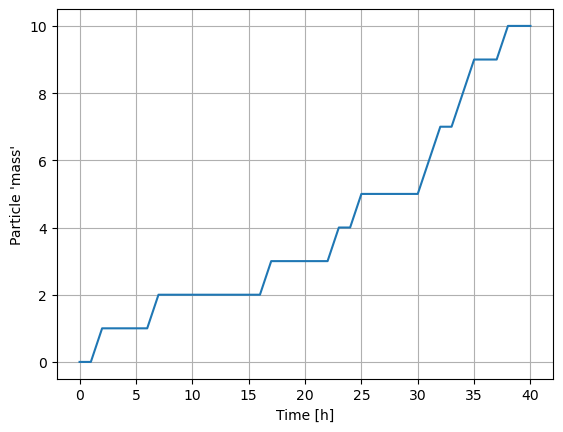

In [83]:
ds_out = xr.open_zarr("growingparticles.zarr")
plt.plot((ds_out.time.values[:].T-ds.time.values[0]).astype('timedelta64[h]'), ds_out.mass.T)
plt.grid()
plt.xlabel("Time [h]")
plt.ylabel("Particle 'mass'")
plt.show()